# DEM post-processing: vertical adjustment with GCPs and error assessment

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xdem
import geoutils as gu
import json

# Define paths in directory
data_dir = f"/Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/"
site_name = "Banner"
date = "20240419-2"
dem_fn = os.path.join(data_dir, site_name, date, f"{site_name}_{date}_DEM.tif")
nmad_fn = os.path.join(data_dir, site_name, date, f"{site_name}_{date}_nmad_mos.tif")
# dem_fn = os.path.join(data_dir, site_name, date, "COPDEM+AllLidar_ba-noRefDEM_MCS_20241003_DEM.tif")
# nmad_fn = os.path.join(data_dir, site_name, date, f"COPDEM+AllLidar_ba-noRefDEM_{site_name}_{date}_nmad_mos.tif")
ss_mask_fn = os.path.join(data_dir, site_name, date, "stable_surfaces", "stable_surfaces_mask.tif")
snow_mask_fn = os.path.join(data_dir, site_name, date, "stable_surfaces", "snow_mask.tif")
if site_name=='JacksonPeak':
    refdem_fn = os.path.join(data_dir, site_name, "refdem", "USGS_LPC_ID_FEMAHQ_2018_D18_merged_filtered_filled.tif")
    gcp_fn = os.path.join(data_dir, site_name, "snotel", "JacksonPeak_snotel_site_info.gpkg")
    gcp_elev = 1.45
else:
    refdem_fn = os.path.join(data_dir, site_name, 'refdem', f'{site_name}_REFDEM_WGS84.tif')
    gcp_fn = "/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/ITD_Functional_Class/ITD_HWY_21.shp"
    gcp_elev = 0
out_dir = os.path.join(data_dir, site_name, date, "post_process")

# Check that input files exist
for file, name in [[dem_fn, 'DEM'], [refdem_fn, 'Reference DEM'], [nmad_fn, "NMAD"],
                   [ss_mask_fn, 'Stable surfaces'], [snow_mask_fn, 'Snow mask'], [gcp_fn, "GCP"]]:
    if not os.path.exists(file):
        print(f"{name} not found, please fix before continuing")

# Make output directory
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Vertical adjustment

/Users/raineyaberle/opt/anaconda3/envs/skysat_stereo/lib/python3.11/site-packages/geoutils/raster/raster.py:1719: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


Vertical shift = 3.62 m


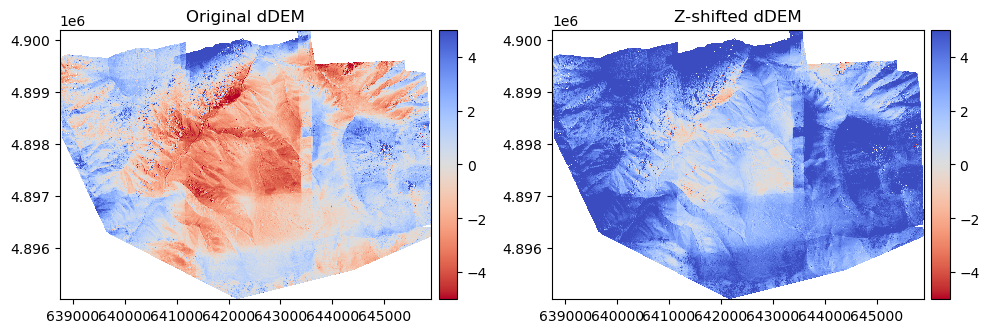

Z-Shifted DEM saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/Banner/20240419-2/post_process/Banner_20240419-2_DEM_GCPshift.tif


In [3]:
dem_zshift_fn = os.path.join(out_dir, os.path.splitext(os.path.basename(dem_fn))[0] + '_GCPshift.tif')
if not os.path.exists(dem_zshift_fn):
    # Load input files
    dem = xdem.DEM(dem_fn, load_data=True)
    refdem = xdem.DEM(refdem_fn, load_data=True).reproject(dem)
    gcp = gu.Vector(gcp_fn).reproject(dem)
    gcp = gcp.create_mask(dem)
    nmad = gu.Raster(nmad_fn, load_data=True).reproject(dem)
    
    # Calculate dDEM
    ddem = dem - refdem

    # Mask outliers
    mask = ((nmad >= 10) | (np.abs(ddem.data) >= 10))
    dem.set_mask(mask)
    ddem.set_mask(mask)
    
    # Apply vertical shift to DEM using GCP
    shift = xdem.coreg.VerticalShift().fit(refdem, dem, gcp)
    zshift = shift.meta['outputs']['affine']['shift_z']
    print(f"Vertical shift = {np.round(float(zshift),2)} m")
    dem_zshift = dem + zshift - gcp_elev   
    ddem_zshift = ddem + zshift - gcp_elev
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ddem.plot(cmap='coolwarm_r', vmin=-5, vmax=5, ax=ax[0])
    ax[0].set_title('Original dDEM')
    ddem_zshift.plot(cmap='coolwarm_r', vmin=-5, vmax=5, ax=ax[1])
    ax[1].set_title('Z-shifted dDEM')
    plt.show()
    
    # Save results to file
    dem_zshift.save(dem_zshift_fn)
    print('Z-Shifted DEM saved to file:', dem_zshift_fn)

else:
    dem_zshift = xdem.DEM(dem_zshift_fn)
    print('Z-Shifted DEM loaded from file.')
    

## Slope correction

/Users/raineyaberle/opt/anaconda3/envs/skysat_stereo/lib/python3.11/site-packages/geoutils/raster/geotransformations.py:98: UserWarning: For reprojection, nodata must be set. Setting default nodata to -99999. You may set a different nodata with `nodata`.
  warnings.warn(


Vertical shift = 3.98 m


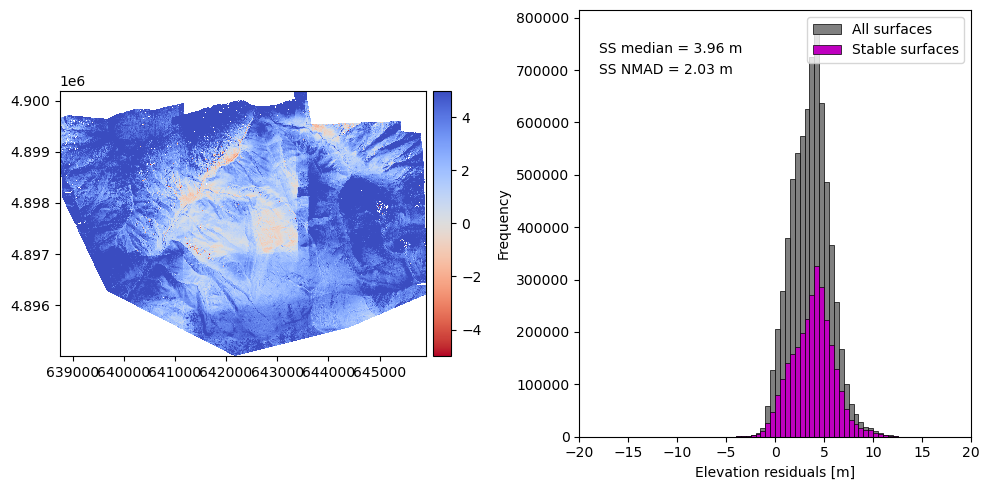

Slope-corrected DEM saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/Banner/20240419-2/post_process/Banner_20240419-2_DEM_GCPshift_slope-corrected.tif
Figure saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/Banner/20240419-2/post_process/Banner_20240419-2_DEM_GCPshift_slope-corrected.png


In [4]:
dem_slopecorr_zshift_fn = dem_zshift_fn.replace('.tif', '_slope-corrected.tif')
if not os.path.exists(dem_slopecorr_zshift_fn):
    # Load inputs
    refdem = xdem.DEM(refdem_fn).reproject(dem_zshift)
    ss_mask = gu.Raster(ss_mask_fn).reproject(dem_zshift)
    ss_mask = (ss_mask==1)
    gcp = gu.Vector(gcp_fn).reproject(dem_zshift)
    gcp = gcp.create_mask(dem_zshift)
    
    # Slope correction
    corr = xdem.coreg.TerrainBias(terrain_attribute="slope", fit_or_bin='bin').fit(refdem, dem_zshift, ss_mask)
    dem_slopecorr = corr.apply(dem_zshift)
    ddem_slopecorr = dem_slopecorr - refdem
    
    # Apply vertical shift to DEM using GCP
    shift = xdem.coreg.VerticalShift().fit(refdem, dem_slopecorr, gcp)
    zshift = shift.meta['outputs']['affine']['shift_z']
    print(f"Vertical shift = {np.round(float(zshift),2)} m")
    dem_slopecorr_zshift = shift.apply(dem_slopecorr)   
    ddem_slopecorr_zshift = shift.apply(ddem_slopecorr)
    
    # Calculate stable surface stats
    ddem_slopecorr_zshift_ss = ddem_slopecorr_zshift[ss_mask]
    ss_median, ss_nmad = np.ma.median(ddem_slopecorr_zshift_ss), xdem.spatialstats.nmad(ddem_slopecorr_zshift_ss)
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    bins = np.arange(-20, 20.2, 0.5)
    ddem_slopecorr_zshift.plot(cmap='coolwarm_r', vmin=-5, vmax=5, ax=ax[0])
    ax[1].hist(ddem_slopecorr_zshift.data.ravel(), color='gray', edgecolor='k', linewidth=0.5, 
               bins=bins, label='All surfaces')
    ax[1].hist(ddem_slopecorr_zshift_ss.data.ravel(), color='m', edgecolor='k', linewidth=0.5, 
               bins=bins, label='Stable surfaces')
    ax[1].text(0.05, 0.9, f"SS median = {np.round(float(ss_median),2)} m", transform=ax[1].transAxes)
    ax[1].text(0.05, 0.85, f"SS NMAD = {np.round(float(ss_nmad),2)} m", transform=ax[1].transAxes)
    ax[1].set_xlim(bins[0], bins[-1])
    ax[1].set_xlabel('Elevation residuals [m]')
    ax[1].set_ylabel('Frequency')
    ax[1].legend(loc='upper right')
    fig.tight_layout()
    plt.show()
    
    # Save slope-corrected DEM and to file
    dem_slopecorr_zshift.save(dem_slopecorr_zshift_fn)
    print('Slope-corrected DEM saved to file:', dem_slopecorr_zshift_fn)
    fig_fn = dem_slopecorr_zshift_fn.replace('.tif', '.png')
    fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
    print('Figure saved to file:', fig_fn)
    
else:
    dem_slopecorr_zshift = xdem.DEM(dem_slopecorr_zshift_fn)
    print('Slope-corrected DEM loaded from file.')

## Construct snow depth map

/Users/raineyaberle/opt/anaconda3/envs/skysat_stereo/lib/python3.11/site-packages/geoutils/raster/geotransformations.py:98: UserWarning: For reprojection, nodata must be set. Setting default nodata to -99999. You may set a different nodata with `nodata`.
  warnings.warn(


Snow depth map saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/Banner/20240419-2/post_process/Banner_20240419-2_DEM_GCPshift_snow_depth.tif


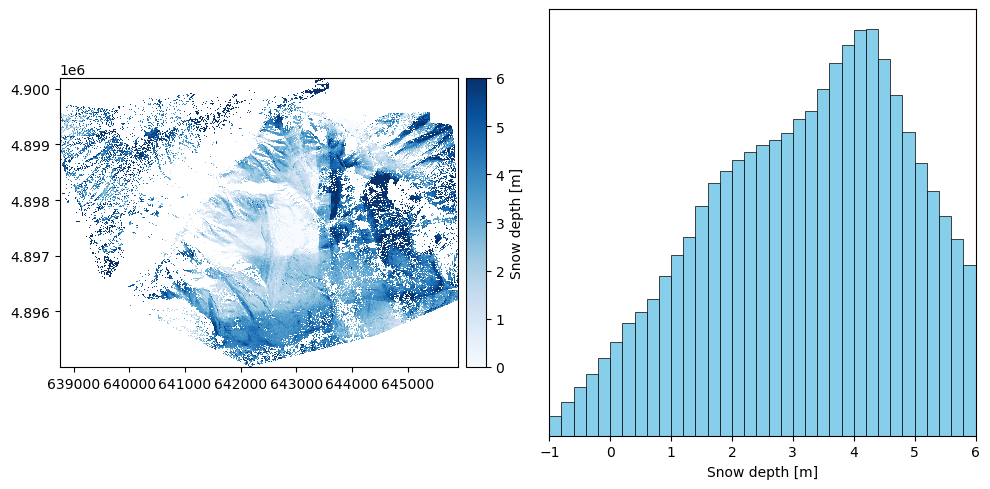

In [5]:
sd_fn = os.path.splitext(dem_zshift_fn)[0] + '_snow_depth.tif'
if not os.path.exists(sd_fn):
    # Load input files
    dem = xdem.DEM(dem_slopecorr_zshift_fn)
    refdem = xdem.DEM(refdem_fn).reproject(dem)
    snow_mask = gu.Raster(snow_mask_fn).reproject(dem)
    snow_mask = (snow_mask == 1)
    
    # Calculate dDEM
    ddem = dem - refdem
    
    # Mask snow-free surfaces
    ddem.set_mask(~snow_mask)
    
    # Save to file
    ddem.save(sd_fn)
    print('Snow depth map saved to file:', sd_fn)
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ddem.plot(cmap='Blues', vmin=0, vmax=6, ax=ax[0], cbar_title='Snow depth [m]')
    ax[1].hist(ddem.data.ravel(), bins=np.arange(-1,6.1, step=0.2), facecolor='skyblue', edgecolor='k', linewidth=0.5)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Snow depth [m]')
    ax[1].set_xlim(-1,6)
    fig.tight_layout()
    plt.show()
    
else:
    print('Snow depth map already exists in file, skipping.')
    

## Estimate resolution at which terrain parameters should be sampled by modeling the semivariogram

In [ ]:
res_dict_fn = os.path.join(data_dir, site_name, 'refdem', 'refdem_terrain_sampling_resolutions.json')
if not os.path.exists(res_dict_fn):

    def calculate_variogram_range(raster):
        # Calculate the empirical variogram
        print('Calculating the empirical variogram...')
        var = xdem.spatialstats.sample_empirical_variogram(raster)
        # Model the spherical variogram using a double-range model
        print('Modeling the variogram...')
        func_sum_vgm, params_vgm = xdem.spatialstats.fit_sum_model_variogram(
            list_models=["Spherical"], empirical_variogram=var
            )
        # Plot
        xdem.spatialstats.plot_variogram(var, 
                                        list_fit_fun=[func_sum_vgm],
                                        xscale_range_split=[10, 100, 1000, 10000])
        plt.show()
        # Estimate correlation length using the range
        range = np.round(float(params_vgm['range'].values[0]))
        print('Modeled range = ', range)
        return range

    def calculate_terrain_parameters(refelev, elev):
        # Calculate terrain params
        slope = refelev.slope()
        aspect = refelev.aspect()

        # Calculate best sampling resolution from modeled variogram range
        res0 = refelev.res
        refelev_res = calculate_variogram_range(refelev)
        slope_res = calculate_variogram_range(slope)
        aspect_res = calculate_variogram_range(aspect)
        
        # Resample using new res
        elev = elev.reproject(res=(refelev_res, refelev_res))
        slope = slope.reproject(res=(slope_res, slope_res))
        aspect = aspect.reproject(res=(aspect_res, aspect_res))
        
        # Reproject back to DEM grid for later calculations
        elev = elev.reproject(elev)
        slope = slope.reproject(elev)
        aspect = aspect.reproject(elev)
        
        # Set no-data values to NaN
        elev.set_nodata(np.nan)
        slope.set_nodata(np.nan)
        aspect.set_nodata(np.nan)
    
        # Save results in dictionary
        res_dict = {'original_sill_m': json.dumps(res0[0]),
                    'elevation_sill_m': json.dumps(refelev_res),
                    'slope_sill_m': json.dumps(slope_res),
                    'aspect_sill_m': json.dumps(aspect_res)}
        
        return elev, slope, aspect, res_dict

    # Load input files
    dem = xdem.DEM(dem_zshift_fn)
    refdem = xdem.DEM(refdem_fn).reproject(dem)

    # Calculate terrain parameters
    elev, slope, aspect, res_dict = calculate_terrain_parameters(refdem, dem)
    with open(res_dict_fn, 'w') as f:
        json.dump(res_dict, f)
    print('Terrain sampling resolutions saved to file:', res_dict_fn)

else:
    print('Estimated terrain sampling already exists, loaded from file.')
    with open(res_dict_fn, 'r') as f:
        res_dict = json.load(f)

res_dict



## Estimate spatial correlation in errors